# Regression and Classification

Supporting code for the paper titled [Discovering latent topology and geometry in data: a law of large dimension](https://arxiv.org/abs/2208.11665). Further details and any references in the notebook to theorems, assumptions, etc. can be found there. 

## Package load

In [1]:
import numpy as np

from scipy import sparse
import matplotlib.ticker as mtick

import time
from sklearn import datasets
from sklearn.manifold import Isomap
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.manifold import TSNE
from keras.datasets import mnist

import matplotlib.pyplot as plt
from matplotlib import cm
plt.rcParams['figure.figsize'] = [9,5] #globally set figure size
params = {'legend.fontsize': 'small',
         'axes.labelsize': 'small',
         'axes.titlesize':'small',
         'xtick.labelsize':8,
         'ytick.labelsize':8}
plt.rcParams.update(params)

from tqdm.notebook import tqdm, trange

/home/ag16115/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


## Functions

In [2]:
def pc_scores(X, r, return_eig = None):
    U, s, Vh = sparse.linalg.svds(X,k=r)
    idx = s.argsort()[::-1] 
    s = s[idx]
    Vh = Vh[idx,:]
    Y = X @ Vh.T
    if return_eig is not None:
        return Y, s
    else:
        return Y

## LMS model and PC score

<div class="alert alert-block alert-success">
<b>Latent Metric Space model:</b>
The data matrix $\mathbf{Y}\in\mathbb{R}^{n\times p}$ is defined by:
\begin{equation}
\mathbf{Y}_{ij} := X_{j}(Z_{i})+\sigma\mathbf{E}_{ij}\label{eq:model}
\end{equation}
for some $\sigma\geq0$. 
</div>

Where, 
* **Latent variables:** $Z_{1},\ldots,Z_{n}$ are random elements of a compact metric space $(\mathcal{Z},d_{\mathcal{Z}})$, i.i.d. according to a Borel probability measure $\mu$ supported on $\mathcal{Z}$. 
* **Random fields:** $X_{1},\ldots,X_{p}$ are independent but not necessarily identically distributed, $\mathbb{R}$-valued and square-integrable random fields, each with index set $\mathcal{Z}$. That is, for each $z\in\mathcal{Z}$ and $j=1,\ldots,p$, $X_{j}(z)$ is an $\mathbb{R}$-valued random variable such that $\mathbb{E}[|X_{j}(z)|^{2}]<\infty$.
* **Noise:** $\mathbf{E}\in\mathbb{R}^{p\times n}$ is a matrix of random variables whose elements are each zero-mean and unit-variance. The columns of $\mathbf{E}$ are assumed independent and elements in distinct rows of $\mathbf{E}$ are assumed pairwise uncorrelated.
***

<div class="alert alert-block alert-success">
<b>PC scores:</b> For data matrix $Y \in \mathbb{R}^{n\times p}$ the PC scores are defined by:
$$[\zeta_1| \dots | \zeta_n]^\top = \mathbf{Y} \mathbf{V}_{\mathbf{Y}} = p^{1/2} \mathbf{U}_{\mathbf{Y}} \boldsymbol{\Lambda}_{\mathbf{Y}} ^{1/2}. $$
where $\boldsymbol{\Lambda}_{\mathbf{Y}}\in\mathbb{R}^{r\times r}$
is the diagonal matrix whose diagonal elements are the $r$ largest eigenvalues of $p^{-1}\mathbf{Y}\mathbf{Y}^{\top}$, and the columns
of $\mathbf{U}_{\mathbf{Y}}\in\mathbb{R}^{n\times r}$ are orthonormal
eigenvectors associated with these eigenvalues and $\mathbf{V}_{\mathbf{Y}}\in\mathbb{R}^{p\times r}$ are orthonormal eigenvectors associated with the $r$ largest eigenvalues of $\mathbf{Y}^{\top}\mathbf{Y}$.
</div>

***

# Introduction

We explore how the Latent Metric Space model can be used with supervised learning tasks - suppose we also observe response variables modelled as $m(Z_1) + W_1, \dots, m(Z_{n-1}) + W_{n-1}$ where $m$ is some unknown function, the $W_i$ are noise disturbances and we wish to predict $m(Z_n)$. Then consider the following.

<div class="alert alert-block alert-success">
    
***
**Algorithm** Regression on $\mathcal{M}$
***
    
**Input:**  data matrix $\mathbf{Y}\in\mathbb{R}^{n\times p}$  and responses $m(Z_1) + W_1, \dots, m(Z_{n-1}) + W_{n-1}$

* Compute the $r$-dimensional PC scores $p^{-1/2}\zeta_{1},\ldots,p^{-1/2}\zeta_{n}$,
to reduce data from high dimension $p$ to moderate dimension $r$.
* Fit a regression model with responses $m(Z_1) + W_1, \dots, m(Z_{n-1}) + W_{n-1}$, and the PC scores $\zeta_1, \dots, \zeta_{n-1}$ as predictors. 
* Evaluate the regression model at $\zeta_n$ to yield prediction $\widehat{m(Z_n)}$ of $m(Z_n)$.
    

**Output:** Prediction  $\widehat{m(Z_n)}$
    
***
</div>

There are many forms of regression and classification that assume that predictors lie on an unknown manifold, here we choose $k$-nearest neighbour regression and classification with default settings ($k=5$, Euclidean distance and uniform weighting) to keep things simple and generic, however, there are more sophisticated alternatives. We expect that improvement on these results would be obtained by using an approach that exploits manifold structure (for example using geodesic distance). To implement the algorithm above, the dimension $r$ of the PC scores needs to be chosen. Below, we perform multiple numerical experiments to look at the impact $r$ on regression and classification performance via an example of each. 

# Regression - Wi-Fi locatisation example

This example uses the [UJIIndoorLoc Data Set](http://archive.ics.uci.edu/ml/datasets/UJIIndoorLoc) (needs to be downloaded to run the code below), with the aim of solving the indoor localisation problem using a WLAN fingerprint-based method (also known as Wi-Fi fingerprinting). Automatic user localisation problems consist of trying to estimate the position of a user by using an electronic device - while outdoor problems can be solved with GPS sensors, indoor localisation is harder due to the loss of GPS signal. 

From the data, the following are used: 
* Attribute 001 (WAP001): Intensity value for WAP001. Negative integer values from -104 to 0 and +100. Positive value 100 used if WAP001 was not detected.
*  ...
* Attribute 520 (WAP520): Intensity value for WAP520. Negative integer values from -104 to 0 and +100. Positive Vvalue 100 used if WAP520 was not detected.
* Attribute 521 (Longitude): Longitude. Negative real values from -7695.9387549299299000 to -7299.786516730871000
* Attribute 522 (Latitude): Latitude. Positive real values from 4864745.7450159714 to 4865017.3646842018.

Predictors are received signal strengths from $p = 520$ Wi-Fi routers, recorded at $n = 2000$ locations across three buildings at Universitat Jaume I, Spain. This is a randomly chosen subset of data for 19,937 locations published.

In [3]:
#assess performance of knn regression as a function of embedding dimension

covs_and_resp = np.loadtxt('trainingData.csv', delimiter=',',skiprows=1, dtype=float )
#first 520 columns are wifi data
#remaining 9 cols are LONGITUDE,LATITUDE,FLOOR,BUILDINGID,SPACEID,RELATIVEPOSITION,USERID,PHONEID,TIMESTAMP
np.random.seed(123)
np.random.shuffle(covs_and_resp)

col_resp = np.array([520, 521],dtype=int) #column of the responses of interest
num_response = col_resp.size

#full data set has n=19937 rows
response_mat = covs_and_resp[0:2000,col_resp]
covariates_mat = covs_and_resp[0:2000,0:520]

(n,p) = covariates_mat.shape
print(n,p)

#centering
covariates_mat = covariates_mat - covariates_mat.mean(axis=0)

r = np.min((n,p))-1

2000 520


In [4]:
zeta, s_loc = pc_scores(covariates_mat, r, return_eig = True)
# factor of p^-.5 included - see main consistency theorem 
zeta = p**-.5 * zeta

We can view the PC scores coloured by the two response variables: 

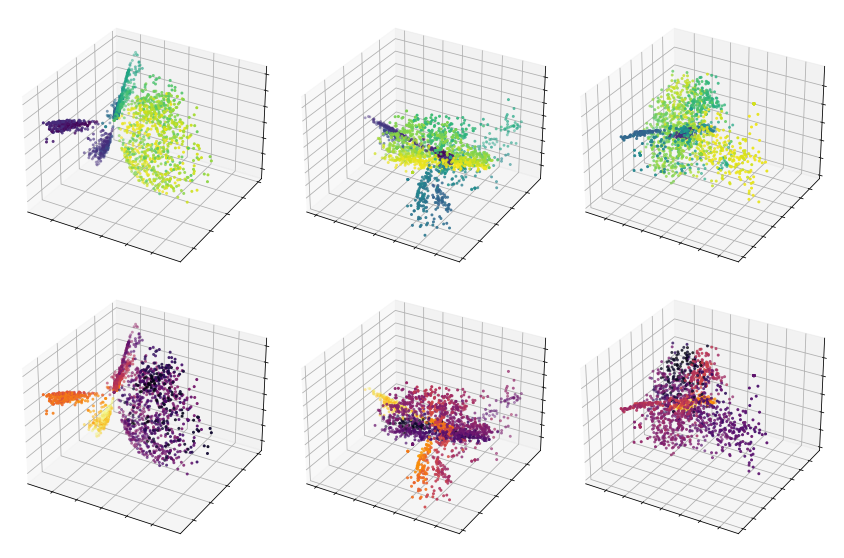

In [5]:
fig = plt.figure(figsize=(15,10))

colour = response_mat[:,0] #choose one of the response variables to colour PC scores
my_cmap = 'viridis'

ax = fig.add_subplot(231, projection='3d')
ax.scatter(zeta[:,0], zeta[:,1], zeta[:,2],  marker='o', s=4, c=colour, cmap=my_cmap)
ax.tick_params(labelbottom=False, labelleft=False)

ax = fig.add_subplot(232, projection='3d')
ax.scatter(zeta[:,3], zeta[:,4], zeta[:,5], marker='o',  s=4, c=colour, cmap=my_cmap)
ax.tick_params(labelbottom=False, labelleft=False)

ax = fig.add_subplot(233, projection='3d')
ax.scatter(zeta[:,6], zeta[:,7], zeta[:,8], marker='o', s=4, c=colour, cmap=my_cmap)
ax.tick_params(labelbottom=False, labelleft=False)

colour = response_mat[:,1]
my_cmap = 'inferno'

ax = fig.add_subplot(234, projection='3d')
ax.scatter(zeta[:,0], zeta[:,1], zeta[:,2],  marker='o', s=4, c=colour, cmap=my_cmap)
ax.tick_params(labelbottom=False, labelleft=False)

ax = fig.add_subplot(235, projection='3d')
ax.scatter(zeta[:,3], zeta[:,4], zeta[:,5], marker='o',  s=4, c=colour, cmap=my_cmap)
ax.tick_params(labelbottom=False, labelleft=False)

ax = fig.add_subplot(236, projection='3d')
ax.scatter(zeta[:,6], zeta[:,7], zeta[:,8], marker='o', s=4, c=colour, cmap=my_cmap)
ax.tick_params(labelbottom=False, labelleft=False)
plt.subplots_adjust(hspace = 0, wspace= 0)

We can also use PCA followed by $t$-SNE to visualise the data in 2 dimensions (coloured by the two response variables): 

In [6]:
#t-SNE to reduce to 3 dimensions for visualization
tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(zeta[:,0:25])

/home/ag16115/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ag16115/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


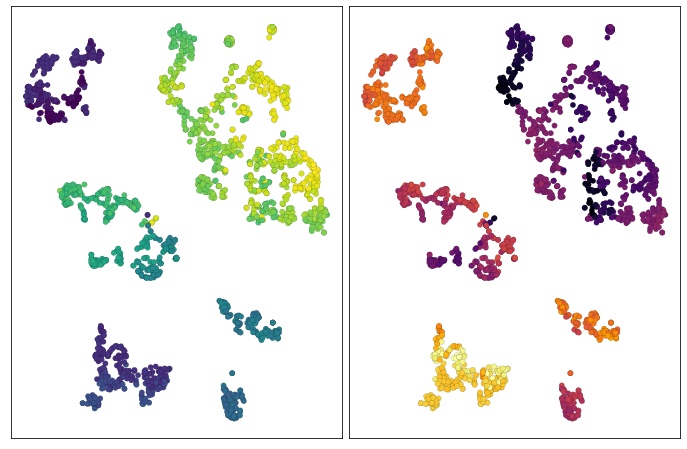

In [7]:
fig = plt.figure(figsize=(20,7.5))

ax = fig.add_subplot(131)
im1 = ax.scatter(tsne_results[:,0],tsne_results[:,1],marker='o',c=response_mat[:,0], edgecolor='black',linewidth=.1, s=30, cmap='viridis')
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)

ax = fig.add_subplot(132)
im2  = ax.scatter(tsne_results[:,0],tsne_results[:,1],marker='o',c=response_mat[:,1], edgecolor='black',linewidth=.1, s=30, cmap='inferno')
ax.tick_params(labelbottom=False, labelleft=False)
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)

fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.8,
                    wspace=0.02, hspace=0.02)

# fig.colorbar(im1, ax=ax, location='right', shrink=1)
# fig.colorbar(im2, ax=ax, location='right',  shrink=1)

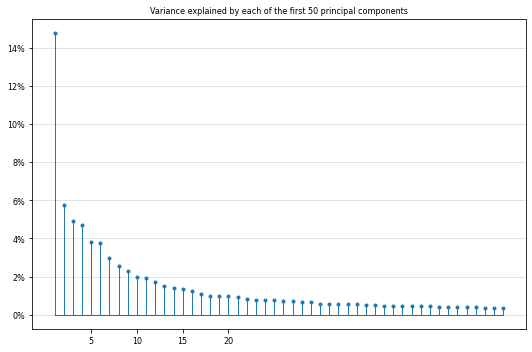

In [8]:
fig = plt.figure(figsize = (7.5,5))
ax = fig.add_subplot(111)
r_plot = 50
percent_var = s_loc[0:r_plot]**2/sum(s_loc**2)

markerline, stemline, baseline, = ax.stem(range(1,r_plot+1),100*percent_var)
ax.set_xticks([5,10,15,20])
ax.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))
ax.grid(axis='y', linestyle='--', linewidth=0.5)
ax.set_title(f'Variance explained by each of the first {r_plot} principal components', fontsize = 8)

plt.setp(stemline, linewidth = 1)
plt.setp(markerline, markersize = 3)
plt.setp(baseline, linewidth = 1)

fig.subplots_adjust(hspace=-.2)
fig.tight_layout()

The following performs $k$-nearest neighbour regression across $200$ randomly chosen $70/30$ train/test splits of the data. 

In [9]:
n_reps = 200 #number of random test/train splits

neigh = KNeighborsRegressor(n_neighbors=5)
r_max_plot = r
r_arr_loc = np.arange(1,r_max_plot+1, step=5) #range of embedding dimensions to consider when doing regression
r_arr_count = r_arr_loc.shape[0]

scores_loc = np.zeros((n_reps,r_arr_count,num_response))
             
for i_rep in trange(n_reps):
    zeta_train, zeta_test, response_train, response_test = train_test_split(zeta, response_mat, test_size=0.3)

    for q in range(r_arr_count):
        neigh.fit(zeta_train[:,0:r_arr_loc[q]], response_train)
        response_pred = neigh.predict(zeta_test[:,0:r_arr_loc[q]])
        scores_loc[i_rep,q,:] = r2_score(response_test,response_pred,multioutput='raw_values')

The blue and red lines show mean $1-R^2$ for the test data, with shaded bands indicating $5\% − 95\%$ percentiles.
The green lines show the ordered eigenvalues of $(np)^{-1} Y^\top Y$.

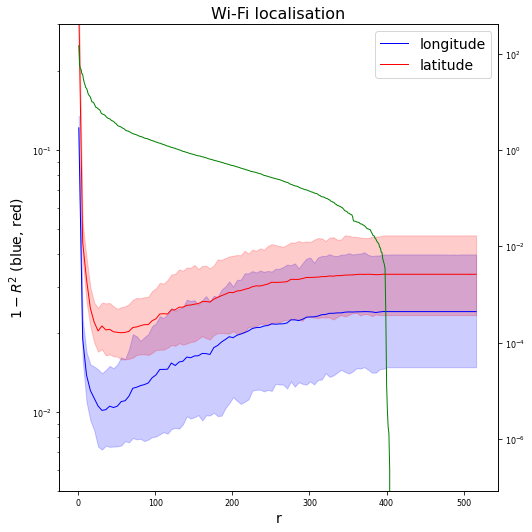

In [10]:
reg_fig = plt.figure(figsize=(7.5,7.5))
ax = reg_fig.add_subplot(111)
ax.plot(r_arr_loc, 1-scores_loc[:,:,0].mean(axis=0), 'b-', linewidth=1,label="longitude")
ax.fill_between(r_arr_loc, 1-np.percentile(scores_loc[:,:,0], 5, axis=0), 1-np.percentile(scores_loc[:,:,0], 95, axis=0),
                 color='blue', alpha=0.2)
ax.plot(r_arr_loc, 1-scores_loc[:,:,1].mean(axis=0), 'r-', linewidth=1,label="latitude")
ax.fill_between(r_arr_loc, 1-np.percentile(scores_loc[:,:,1], 5, axis=0), 1-np.percentile(scores_loc[:,:,1], 95, axis=0),
                 color='red', alpha=0.2)

axR = ax.twinx()
axR.plot(range(1,r_max_plot+1),s_loc[:r_max_plot]**2/(n*p), 'g', linewidth=1, label= 'eigenvalues')
axR.set_yscale('log')

ax.legend(loc="upper right", fontsize=14)
ax.set_ylim(0.005,0.3)
ax.set_yticks((0.01, 0.1))
ax.set_yticklabels(('0.01', '0.1'))
ax.set_yticklabels([], minor=True)
ax.set_yscale('log')
ax.set_xlabel('r', fontsize=14)
ax.set_ylabel('$1-R^2$ (blue, red)', fontsize=14)
ax.set_xticks(range(0,r_max_plot+1,100))
ax.set_title('Wi-Fi localisation', fontsize=16)

reg_fig.tight_layout(w_pad=1)

It is clear that prediction is poor when using $r$ but as $r$ increases, first $1-R^2$ sharply decreases then increases and plateaus. 

# Classification - MNIST example

This section uses the well-known MNIST handwritten digits dataset which is a  set of grayscale images of written characters 0-9, each image consisting of $p = 784 = 28 \times  28$ pixels. The full MNIST database consists of over 60,000 images, we took a random subset of size $n = 2000$. This is a 10-class problem, the class labels being the numbers 0-9 which the images depict.

In [11]:
mnist_data = mnist.load_data()

covs = mnist_data[0][0]
resp = mnist_data[0][1]
covs = covs.flatten().reshape((covs.shape[0],covs.shape[1]*covs.shape[1]))
resp = resp.reshape((resp.shape[0],1))
covs_and_resp = np.hstack((resp,covs))

# col 0  = class label 0-9
# col 1-784 pixel intensities
np.random.seed(456)
np.random.shuffle(covs_and_resp)

col_resp = np.array([0],dtype=int) #column of the responses of interest
num_response = col_resp.size

#the full data set has 50k+ rows, take sample
n = 2000
response_mat = covs_and_resp[0:n,col_resp]
covariates_mat = covs_and_resp[0:n,1:]

(n,p) = covariates_mat.shape
print(n,p)

2000 784


In [12]:
r = np.min((n,p))-1

#do the joint embedding
covariates_mat = covariates_mat - covariates_mat.mean(axis=0)

zeta, s_MNIST = pc_scores(covariates_mat, r, return_eig = True)
# factor of p^-.5 included - see main consistency theorem 
zeta = p**-.5 * zeta

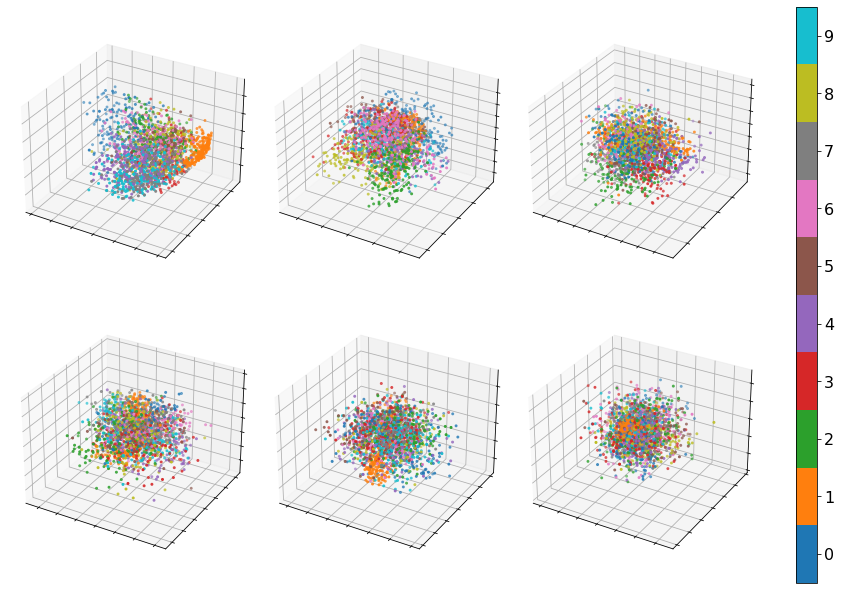

In [13]:
fig = plt.figure(figsize=(15,10))

colour = response_mat #choose one of the response variables to colour PC scores
my_cmap = 'tab10'

ax = fig.add_subplot(231, projection='3d')
ax.scatter(zeta[:,0], zeta[:,1], zeta[:,2],  marker='o', s=4, c=colour, cmap=my_cmap) #c=color,
ax.tick_params(labelbottom=False, labelleft=False)

ax = fig.add_subplot(232, projection='3d')
ax.scatter(zeta[:,3], zeta[:,4], zeta[:,5], marker='o',  s=4, c=colour, cmap=my_cmap)
ax.tick_params(labelbottom=False, labelleft=False)

ax = fig.add_subplot(233, projection='3d')
ax.scatter(zeta[:,6], zeta[:,7], zeta[:,8], marker='o', s=4, c=colour, cmap=my_cmap)
ax.tick_params(labelbottom=False, labelleft=False)

ax = fig.add_subplot(234, projection='3d')
ax.scatter(zeta[:,9], zeta[:,10], zeta[:,11],  marker='o', s=4, c=colour, cmap=my_cmap) #c=color,
ax.tick_params(labelbottom=False, labelleft=False)

ax = fig.add_subplot(235, projection='3d')
ax.scatter(zeta[:,12], zeta[:,13], zeta[:,14], marker='o',  s=4, c=colour, cmap=my_cmap)
ax.tick_params(labelbottom=False, labelleft=False)

ax = fig.add_subplot(236, projection='3d')
im = ax.scatter(zeta[:,15], zeta[:,16], zeta[:,17], marker='o', s=4, c=colour, cmap=my_cmap)
ax.tick_params(labelbottom=False, labelleft=False)


fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.8,
                    wspace=0.02, hspace=0.02)


# add an axes
cb_ax = fig.add_axes([0.83, 0.1, 0.02, .8])
cbar = fig.colorbar(im, cax=cb_ax)

# set the colorbar ticks and tick labels
cbar.set_ticks([.45 + i *.9 for i in range(10)])
cbar.set_ticklabels(np.arange(0, 10, 1),fontsize = 16)


We can also use PCA followed by $t$-SNE to visualise the data in 2 dimensions (coloured by the two response variables): 

In [14]:
#t-SNE to reduce to 3 dimensions for visualization
tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(zeta[:,0:25])

/home/ag16115/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ag16115/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


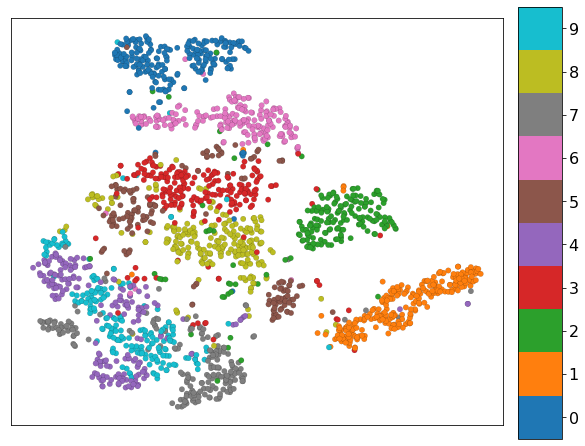

In [15]:
fig = plt.figure(figsize=(30,7.5))

ax = fig.add_subplot(131)
im = ax.scatter(tsne_results[:,0],tsne_results[:,1],marker='o',c=response_mat, edgecolor='black',linewidth=.1, s=30,  cmap=my_cmap)
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)

# add an axes
cb_ax = fig.add_axes([0.36, 0.1, 0.02, .8])
cbar = fig.colorbar(im, cax=cb_ax)

# set the colorbar ticks and tick labels
cbar.set_ticks([.45 + i *.9 for i in range(10)])
cbar.set_ticklabels(np.arange(0, 10, 1),fontsize = 16)

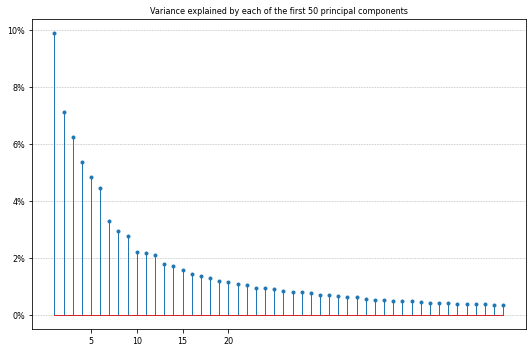

In [16]:
fig = plt.figure(figsize = (7.5,5))
ax = fig.add_subplot(111)
r_plot = 50
percent_var = s_MNIST[0:r_plot]**2/sum(s_MNIST**2)

markerline, stemline, baseline, = ax.stem(range(1,r_plot+1),100*percent_var)
ax.set_xticks([5,10,15,20])
ax.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))
ax.grid(axis='y', linestyle='--', linewidth=0.5)
ax.set_title(f'Variance explained by each of the first {r_plot} principal components', fontsize = 8)

plt.setp(stemline, linewidth = 1)
plt.setp(markerline, markersize = 3)
plt.setp(baseline, linewidth = 1)

fig.subplots_adjust(hspace=-.2)
fig.tight_layout()

The following performs $k$-nearest neighbour classification across $200$ randomly chosen $70/30$ train/test splits of the data. 

In [17]:
n_reps = 200 #number of random test/train splits

neigh = KNeighborsClassifier(n_neighbors=5)
r_max_plot = r
r_arr_MNIST = np.arange(1,r_max_plot, step=5) #range of embedding dimensions to consider when doing regression
r_arr_count = r_arr_MNIST.shape[0]

scores_MNIST = np.zeros((n_reps,r_arr_count))
response_mat = np.ravel(response_mat)
                  
for i_rep in trange(n_reps):
    zeta_train, zeta_test, response_train, response_test = train_test_split(zeta, response_mat, test_size=0.3)

    for q in range(r_arr_count):
        #print(i_rep,q)
        neigh.fit(zeta_train[:,0:r_arr_MNIST[q]], response_train)
        scores_MNIST[i_rep,q] = neigh.score(zeta_test[:,0:r_arr_MNIST[q]],response_test)

The blue line show mean misclassification for the test data, with shaded bands indicating $5\% − 95\%$ percentiles.
The green lines show the ordered eigenvalues of $(np)^{-1} Y^\top Y$.

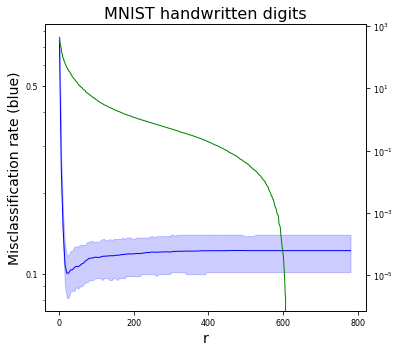

In [18]:
clas_fig = plt.figure(figsize=(15,5))
ax = clas_fig.add_subplot(132)
ax.plot(r_arr_MNIST, 1-scores_MNIST.mean(axis=0), 'b-', linewidth=1)
ax.fill_between(r_arr_MNIST, 1-np.percentile(scores_MNIST, 5, axis=0), 1-np.percentile(scores_MNIST, 95, axis=0),
                 color='blue', alpha=0.2)
ax.set_yscale('log')
ax.set_xlabel('r', fontsize=14)
ax.set_title('MNIST handwritten digits', fontsize=16)
ax.set_xticks([0,200,400,600,800])
ax.set_yticks((0.1, 0.5))
ax.set_yticklabels(('0.1', '0.5'))
ax.set_yticklabels([], minor=True)
axR = ax.twinx()
axR.plot(range(1,r_max_plot+1),s_MNIST[0:r_max_plot]**2/(n*p), 'g', linewidth=1)
axR.set_yscale('log')
ax.set_ylabel('Misclassification rate (blue)', fontsize=14)

clas_fig.tight_layout(w_pad=1)

Similarly to the regression example, it is clear that classification is poor when using $r$ but as $r$ increases, first misclassification sharply decreases then increases and plateaus. 

# Conclusion

Overall these numerical results illustrate that using PCA as a pre-processing step, to reduce predictors from high to moderate dimension, can improve the statistical performance of nearest neighbour regression/classification but reducing dimension further can have a strong deleterious effect. This indicates that 
simple nearest neighbour regression/classification is well suited to embedded manifold structure in predictors. It is also worth noting that in the literature statisticians have warned against using PCA to reduce the dimension of predictors in regression - in some examples particular linear combinations of predictors which are most useful for prediction are also those which happen to have the lowest variance, hence discarding them by performing dimensionality reduction using PCA cripples predictive performance. Hence, whether to use PCA is still a dataset-specific problem. 